In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d meetnagadia/kvasir-dataset

 98% 1.13G/1.15G [00:12<00:00, 140MB/s]
100% 1.15G/1.15G [00:12<00:00, 102MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/kvasir-dataset.zip')
zip_ref.extractall('/content/Data')
zip_ref.close()

In [4]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
path = '/content/Data/kvasir-dataset'

In [6]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    # shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

test_data= tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 4000 files belonging to 8 classes.
Using 3200 files for training.
Found 4000 files belonging to 8 classes.
Using 800 files for validation.


In [7]:
class_names = train_data.class_names
class_names

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

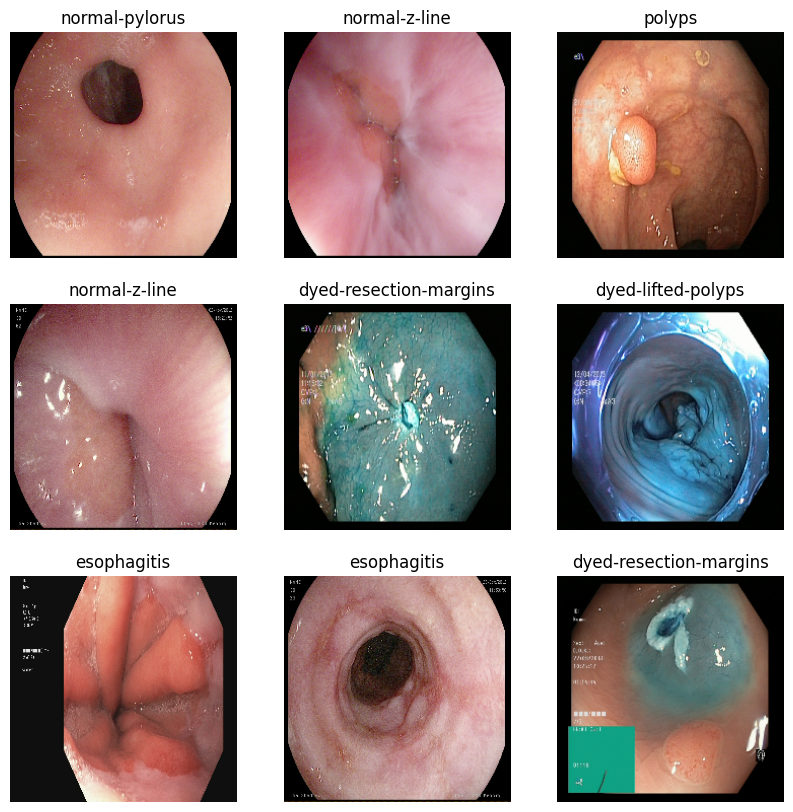

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i+1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(class_names[labels[i]])
      plt.axis('off')

In [9]:
base_model = keras.applications.MobileNetV3Small(input_shape=(224,224,3),
classes=400,
include_top=False,
weights='imagenet')

4334752/4334752 [==============================] - 0s 0us/step


In [10]:
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [11]:
data_augmentation = keras.models.Sequential([
keras.layers.RandomFlip('horizontal'),
keras.layers.RandomRotation(0.2)
])

In [12]:
num_classes = len(class_names)

inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [13]:
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 8)                 4616      
                                                                 
Total params: 943736 (3.60 MB)
Trainable params: 4616 (18.03 

In [14]:
initial_epochs = 10

early = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=1, verbose=1, mode='auto')

check = ModelCheckpoint(monitor='val_accuracy',filepath="./bestmodel.h5", save_best_only=True, verbose=1, mode='auto')

call = [early,check]

In [15]:
history = model.fit(train_data,
validation_data=test_data,
epochs=initial_epochs,
callbacks=call)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 1.3541 - accuracy: 0.5078
Epoch 1: val_accuracy improved from -inf to 0.78125, saving model to ./bestmodel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 37s 271ms/step - loss: 1.3541 - accuracy: 0.5078 - val_loss: 0.7213 - val_accuracy: 0.7812
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.7506
Epoch 2: val_accuracy improved from 0.78125 to 0.83000, saving model to ./bestmodel.h5
100/100 [==============================] - 27s 259ms/step - loss: 0.6720 - accuracy: 0.7506 - val_loss: 0.5179 - val_accuracy: 0.8300
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.8084
Epoch 3: val_accuracy improved from 0.83000 to 0.85750, saving model to ./bestmodel.h5
100/100 [==============================] - 27s 260ms/step - loss: 0.5217 - accuracy: 0.8084 - val_loss: 0.4345 - val_accuracy: 0.8575
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.8438
Epoch 4: val_accuracy improved from 0.85750 to 0.86750, saving model to ./bestmodel.h5
100/100 [==============================] - 27s 25

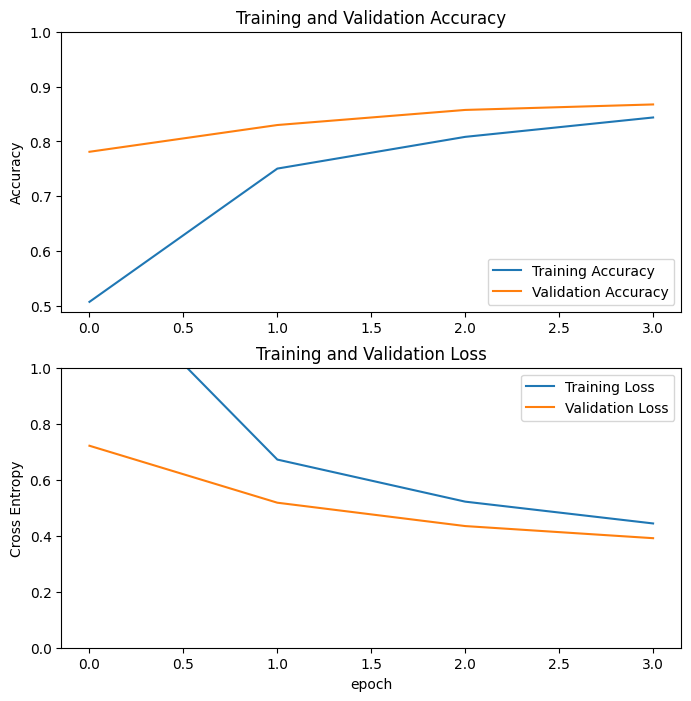

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
test_loss, test_acc = model.evaluate(test_data)
print('test accuracy : ', test_acc)

25/25 [==============================] - 5s 149ms/step - loss: 0.3912 - accuracy: 0.8675
test accuracy :  0.8675000071525574


In [18]:
results = model.evaluate(test_data, verbose=0)

In [19]:
print("Test Loss: {:.5f}".format(results[0]))
print("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

Test Loss: 0.39119
Accuracy on the test set: 86.75%


1/1 [==============================] - 1s 833ms/step


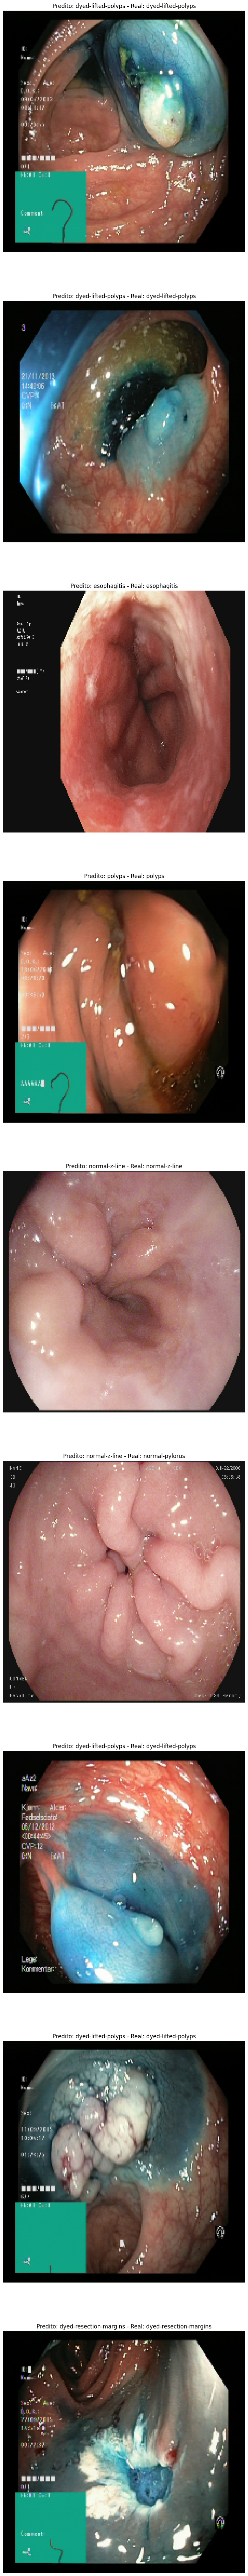

In [20]:
plt.figure(figsize=(10, 100))
for images, labels in test_data.take(1):
  prediction = model.predict(images,batch_size=32)
  for i in range(9):
    ax = plt.subplot(9, 1, i+1)
    pred = np.argmax(prediction[i])
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(f'Predito: {class_names[pred]} - Real: {class_names[labels[i].numpy()]}')
    plt.axis('off')
#Visualize

In [22]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the pre-trained model
model = load_model('/content/bestmodel.h5')

# Define the class labels
class_labels = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum',
                'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']

# Load and preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    return image

# Make predictions on the image
def predict_image(image_path):
    image = preprocess_image(image_path)
    predictions = model.predict(image)
    predicted_class = class_labels[np.argmax(predictions)]
    confidence = np.max(predictions) * 100
    return predicted_class, confidence

# Test the model on an image
image_path = '/content/Data/kvasir-dataset/dyed-lifted-polyps/0053d7cd-549c-48cd-b370-b4ad64a8098a.jpg'
predicted_class, confidence = predict_image(image_path)
print('Predicted class:', predicted_class)
print('Confidence:', confidence)


1/1 [==============================] - 2s 2s/step
Predicted class: dyed-lifted-polyps
Confidence: 91.45830869674683
